---

title: Understanding K-Nearest Neighbors Using MNIST Dataset
date: 2022-09-26
author: Hongtao Hao
slug: knn
draft: false
toc: true
tags: ML

---

To me, K Nearest Neighbors (KNN) is very intuitive. Take classification tasks as an example. What KNN does is to find K training examples that are "closest" to the test example. These K training examples have K labels. We find the most common label, and it is the predicted label for the test example in question. 

How to quantify "closest"? Two simple methods are Euclidean distance or Manhattan distance. 

I'll take the MNIST dataset as an example. 

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Introduction to MNIST dataset

In [61]:
file = '../static/files/large/mnist_train.csv'
# you can download the files here: https://pjreddie.com/projects/mnist-in-csv/

In [62]:
df = pd.read_csv(file)

In [63]:
df.shape

(59999, 785)

In [64]:
# df.head()

![](img/knn-df-head.png)

The above is the MNIST dataset. It has close to 60K training examples, i.e., images. Each training example has 785 columns. The first column is the label and the remaining 784 (28 $\times$ 28) columns are the input. Each of these 784 columns correspondes to a pixel, which I will explain later. 

The raw inputs are RGB values which range from 0 to 255:

In [65]:
np.max(df.to_numpy())

255

We normally would [normalize the inputs](https://stackoverflow.com/a/37421202) so that they values are between 0 (black) and 1 (white). To do that, we divide each pixel value by the number of 255. 

Let's take a look at one example. 

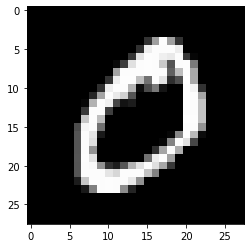

In [66]:
example_to_draw = df.iloc[0, 1:].to_numpy().reshape(28,28)
plt.imshow(example_to_draw, cmap='gray')
plt.show()

## KNN

### Training examples

Since there are 60K examples, for simplicity, I'll randomly choose 10K of them as training examples. 

In [67]:
training_samples = df.sample(10000, random_state = 222)
training_indices = training_samples.index

In [68]:
x_train = (training_samples.iloc[:, 1:]/255).to_numpy()
y_train = training_samples.iloc[:, 0].to_numpy()

In [69]:
x_train.shape, y_train.shape

((10000, 784), (10000,))

In [70]:
Counter(y_train)

Counter({4: 957,
         5: 920,
         2: 1005,
         7: 1060,
         8: 1019,
         1: 1160,
         0: 966,
         9: 974,
         3: 958,
         6: 981})

<AxesSubplot:xlabel='label', ylabel='frequency'>

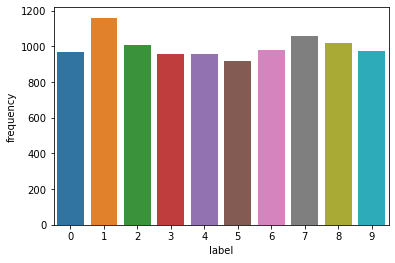

In [71]:
label_counts = pd.DataFrame(Counter(y_train).items(), columns = ['label', 'frequency'])
sns.barplot(data = label_counts, x = 'label', y = 'frequency')

### Test examples

I will have 100 images as test examples. 

In [72]:
testing_samples = df[~df.index.isin(training_indices)].sample(100, random_state = 300)

In [73]:
x_test = (testing_samples.iloc[:, 1:]/255).to_numpy()
y_test = testing_samples.iloc[:, 0].to_numpy()

In [74]:
x_test.shape, y_test.shape

((100, 784), (100,))

<AxesSubplot:xlabel='label', ylabel='frequency'>

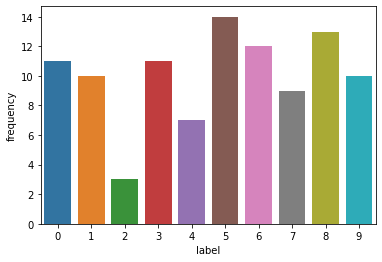

In [75]:
label_counts = pd.DataFrame(Counter(y_test).items(), columns = ['label', 'frequency'])
sns.barplot(data = label_counts, x = 'label', y = 'frequency')

### K-Nearest Neighbors

In [76]:
def eu_distance(v1, v2):
    '''to calculate the euclidean distance of two vectors
        input: vector1, vector2
    '''
    s = np.sum((v1-v2)**2)
    d = np.sqrt(s)
    return d

In [77]:
def knn(test_example, x_train, k):
    
    # calculate the euclidean distance between the test example and 
    # each example x_train. Accumulate these distances to sort later
    distances = np.array([eu_distance(test_example, i) for i in x_train])
    
    # np.argsort sorts the distances in ascending order, and return the index 
    # of items in the original (unsorted) array 
    sorted_idx = np.argsort(distances)
    
    # we only want the k smallest distances
    return sorted_idx[0:k]

Let's take one example. Exciting moment!

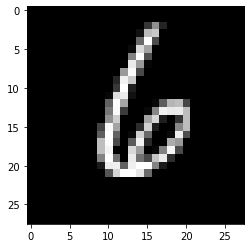

In [78]:
## example 1:
eg1 = x_test[1]
plt.imshow(eg1.reshape(28, 28), cmap='gray')

In [79]:
# Let's say k = 3
k = 3
knn_results = knn(eg1, x_train, k)
knn_results

array([7572, 4714, 5533])

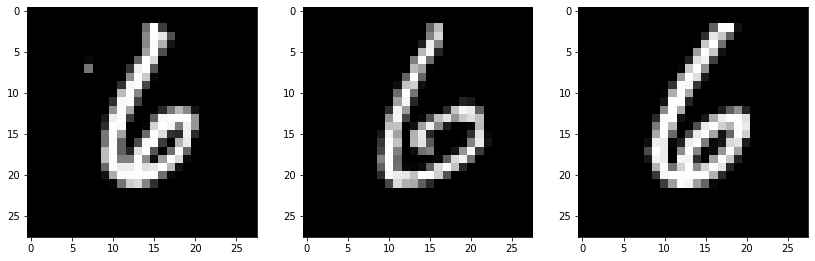

In [80]:
f, axs = plt.subplots(1,3,
                      figsize=(14,5),
                      sharex=False,
                      sharey=False,)
for i in range(k):
    result = knn_results[i]
    axs[i].imshow(x_train[result].reshape(28,28), cmap='gray')

These three nearest neighbors have the label of '6', so the label for `eg1` should be '6' as well. 

In [81]:
y_train[knn_results]

array([6, 6, 6])

Let's have another example:

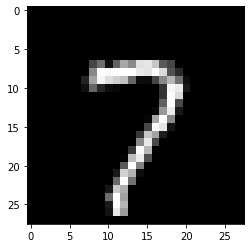

In [82]:
# example 2
eg2 = x_test[90]
plt.imshow(eg2.reshape(28, 28), cmap='gray')

In [83]:
# Let's say k = 3
k = 3
knn_results = knn(eg2, x_train, k)
knn_results

array([9273, 7022, 4709])

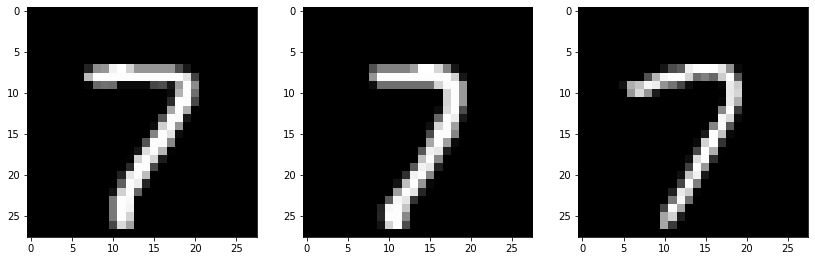

In [84]:
f, axs = plt.subplots(1,3,
                      figsize=(14,5),
                      sharex=False,
                      sharey=False,)
for i in range(k):
    result = knn_results[i]
    axs[i].imshow(x_train[result].reshape(28,28), cmap='gray')

These three nearest neighbors have the label of '7', so the label for `eg2` should be '7' as well. Note that if, for example, two of the three nearest neighbors are '7' and one is '6', we still decide that the label for the testing example is '7' because that is the majorty. 

In [85]:
y_train[knn_results]

array([7, 7, 7])

## Curse of dimensionality

A discussion on KNN is not complete without touching upon the curse of dimensionality. What this curse says is that if we have more features, the performance of KNN will decrease. This is because the K nearest neighbors will be **more dissimilar to** the testing example. 

I will explain in the following. Let us we only have one feature vector, whose values are uniformly distributed between 0 and 1. If we have 1,000 training examples, and for KNN we decide that $K=100$. 

Let us say for the testing example, its feature is 0.4. What will be its 100 nearest neighbors?

In [86]:
d1 = np.random.RandomState(seed = 11).uniform(low=0, high=1, size =1000)

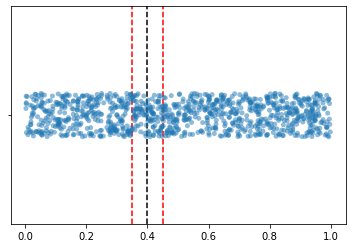

In [87]:
fig, ax = plt.subplots()
sns.stripplot(x= d1, y = None, ax = ax, alpha = 0.5)
ax.axvline(0.4, ls='--', c='black')
ax.axvline(0.35, ls='--', c='red')
ax.axvline(0.45, ls='--', c='red')

Because we assume that values of the feature are uniformly distrbitued, and we want 100 nearest neighbors, it is easy to understand that we want points falling into this interval `[0.35, 0.45]`

But what if we have 2 features and the testing example has a value o 0.4 for the first feature (X1) and 0.6 for the second feature (X2).

In [88]:
d2 = np.random.RandomState(seed = 22).uniform(low=0, high=1, size =1000)
x1 = 0.4
x2 = 0.6

Text(0, 0.5, 'X2')

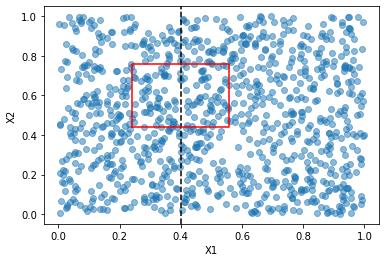

In [89]:
fig, ax = plt.subplots()
ax.scatter(d1, d2, alpha = 0.5)
ax.axvline(x1, ls='--', c='black')
# width of each side
w = np.sqrt(100/1000)/2
# thanks to https://stackoverflow.com/a/72793114 for the following codes
xs = [x1 - w, x1 + w, x1 + w, x1 - w, x1 - w]
ys = [x2 - w, x2 - w, x2 + w, x2 + w, x2 - w]
ax.plot(xs, ys, color = 'red')
plt.xlabel('X1')
plt.ylabel('X2')

How do we come to `w = np.sqrt(100/1000)/2`. I think of it this way. Because the values in X1 and X2 are uniformly distrbuted, and we want 100 (which is 10% of all data points) nearest neighbors, we want a square whose area is the 10% of the total area. That is to say, we want a square whose area is 100/1000. We take the square root to get the lengh of each side. Then we divide the length by 2 to get the interval. 

You can observe that as we have more dimensions, the data points are getting sparser and sparser, and that is why the 100 nearest neighbors are getting further and further away from the testing example (and therefore more and more dissimilar). 

What will happen if we have 100 features? How large will be the hypercube containing the 100 nearest neighbors?

If you think about it, you'll know that the area of this 'hypercube' is always 0.1. When we only have one dimension, the 'hypercube' is a line and that line has a width (or length) of 0.1. When we have two features, we take the square root. Then if we have 100 features, the length of each side of this hypercube is:

$$(10^{-1})^\frac{1}{100}$$

In [90]:
10**(-0.01)

0.9772372209558107

That is extremely large, right? Because each feature is only between 0 and 1. This means that if we have 100 features, then the 100 nearest neighbors are very dissimilar to our tesing example. 